In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_alpha
seed = cfg_seed


# bif_c = 0.1
num_iter_max=200000
# alpha=0.2
alpha=cfg_alpha
vae_lr=5e-4
ratio_lr=5e-4
ratio_early=100
env_name = 'CustomPendulum-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter2_"

loss_list = []
normalized_loss_list = []

print("alpha",alpha)
print(datetime.datetime.now())

alpha 0.1
2023-05-11 09:04:15.405237


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter1")

iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter1 ckpt_iwvi_pendulum_policy_optimization_iter1
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-4.9852)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(7.7174)
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter1


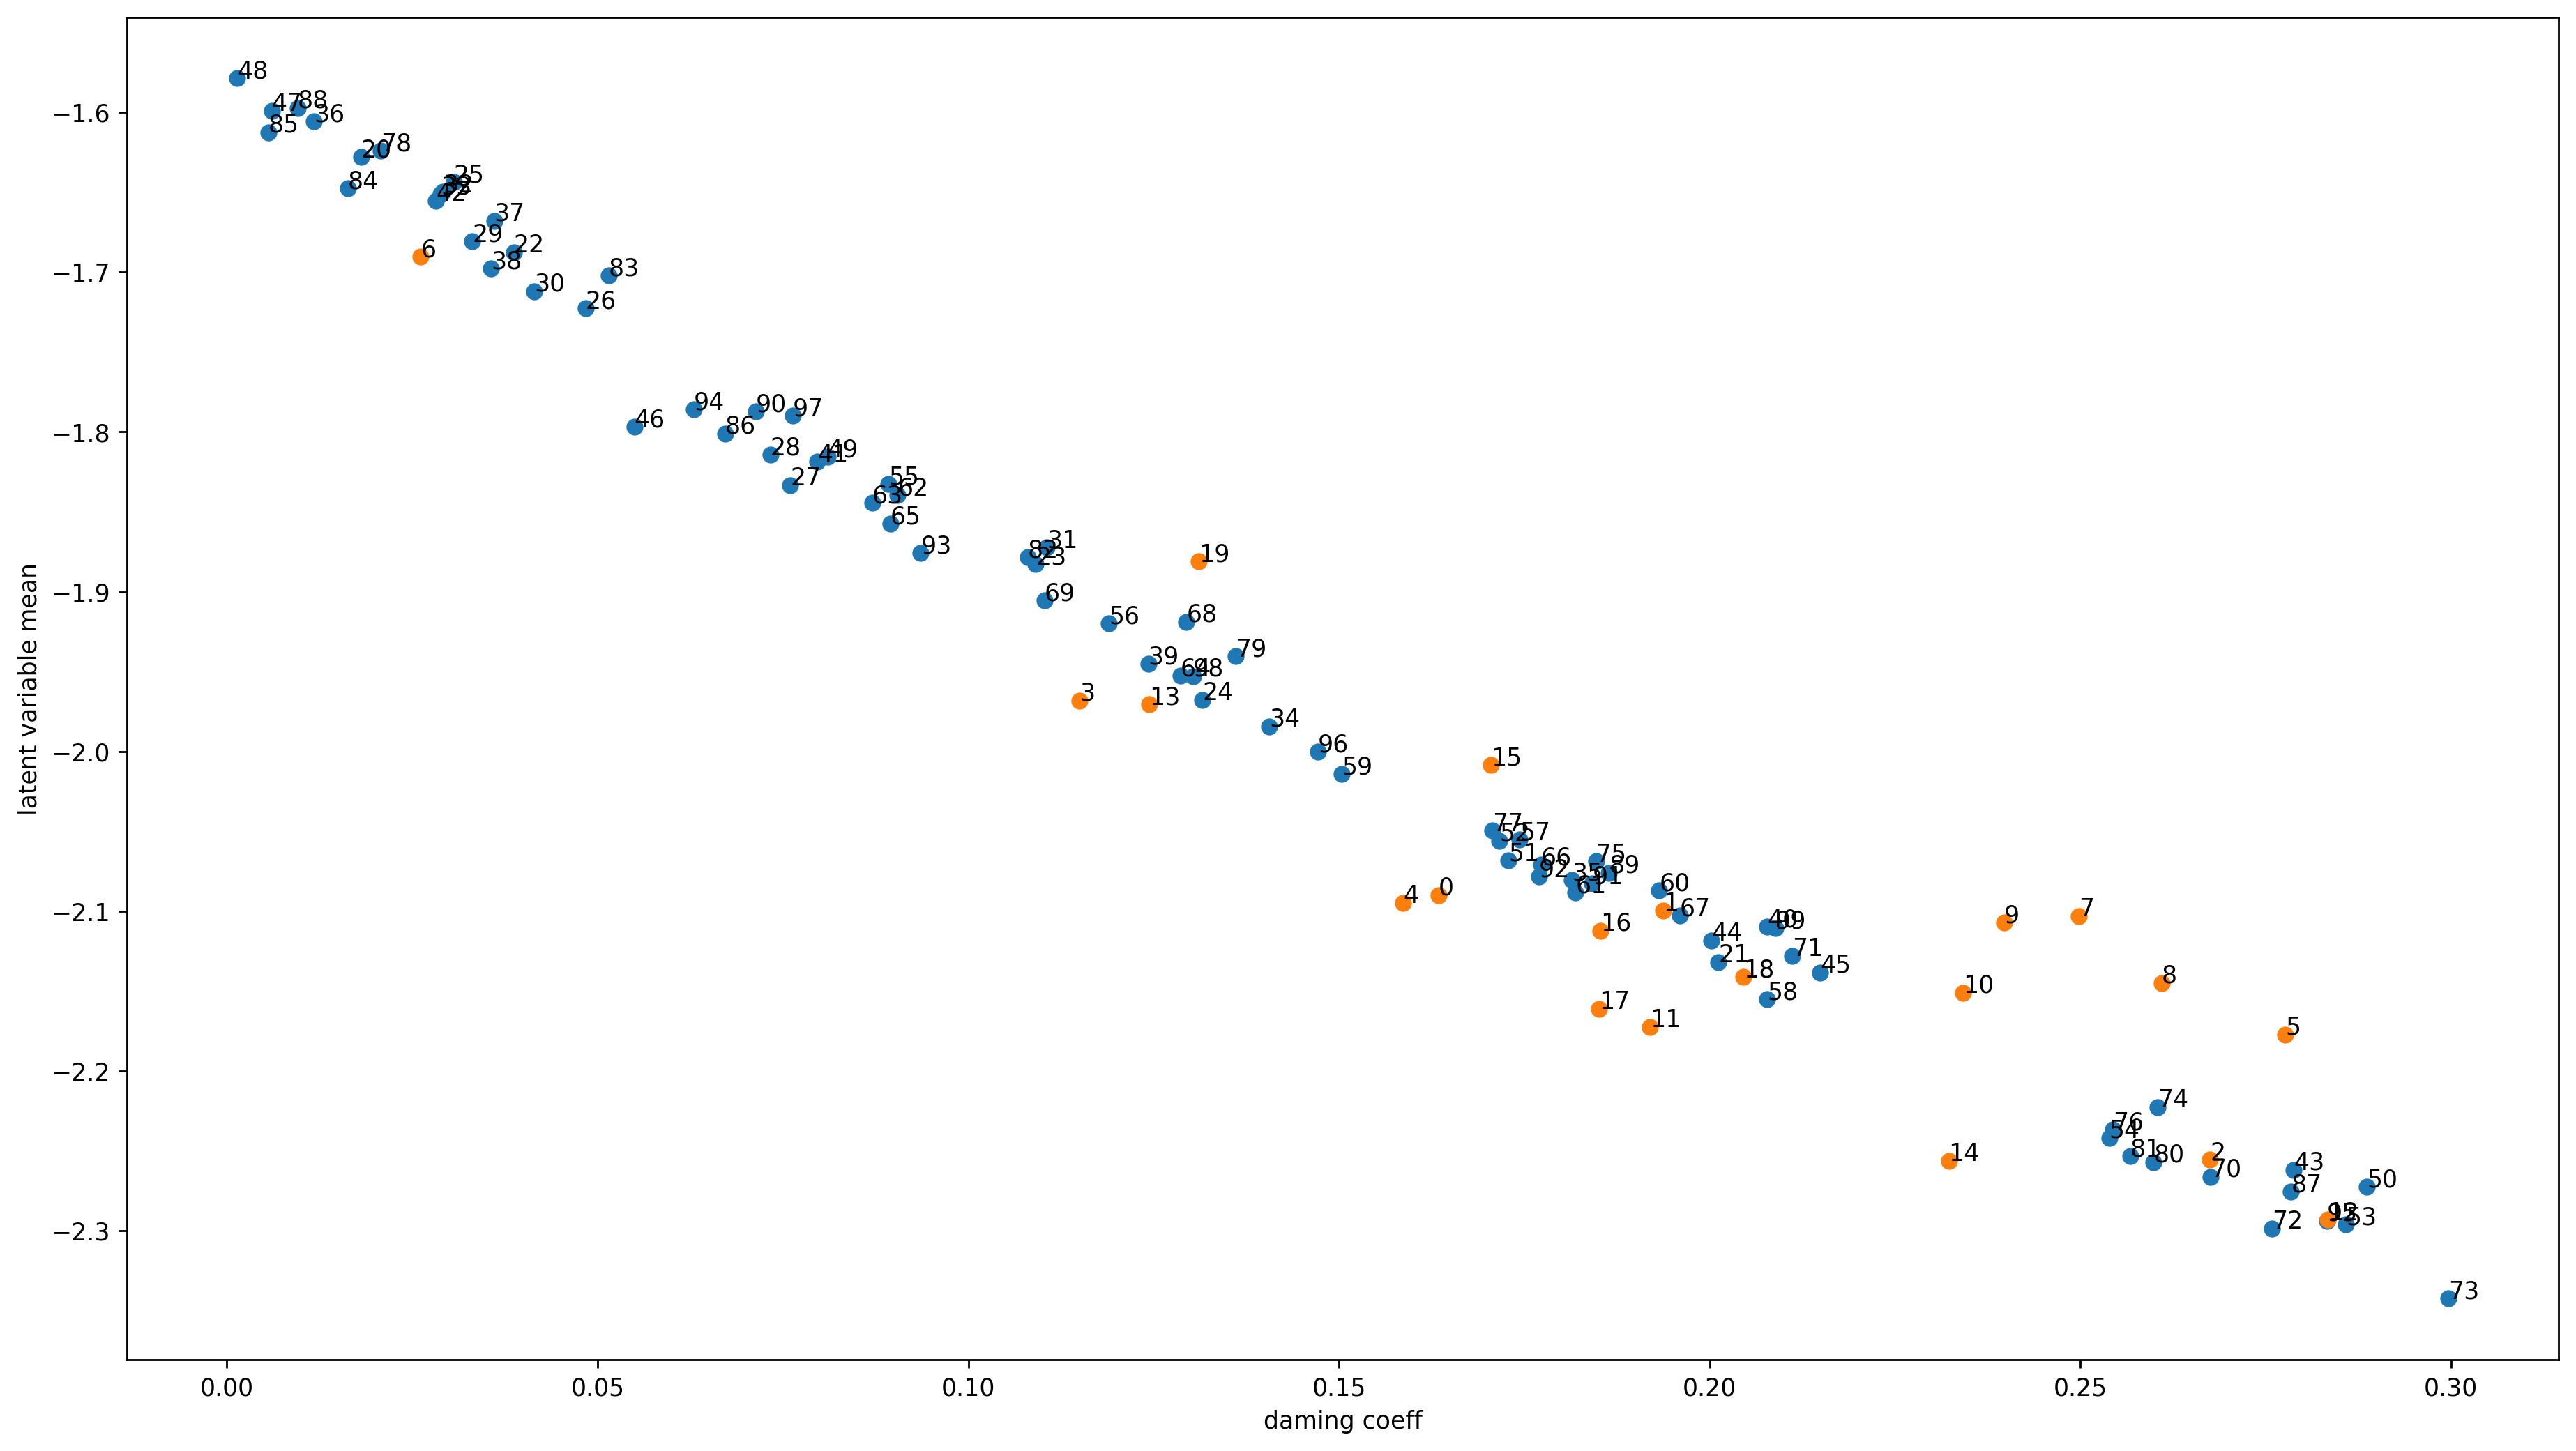

[0.16346495 0.19376823 0.2675319  0.11503246 0.15866848 0.27767899
 0.02613879 0.24978595 0.26100364 0.23974757]
[0.23415875 0.19197631 0.28340068 0.12439858 0.23227011 0.17053018
 0.18529065 0.1850802  0.20454609 0.13110959]
[0.01806764 0.20119136 0.03867789 0.10911323 0.13158045 0.03061344
 0.04839286 0.07598748 0.07332768 0.03311254]
[0.04145489 0.11061755 0.02913038 0.02882952 0.14059536 0.18145366
 0.01175634 0.03605897 0.03561832 0.1242789 ]
[0.20774164 0.07961685 0.02818215 0.27878886 0.20022311 0.21489816
 0.05495741 0.00603226 0.00140864 0.08100239]
[0.28865656 0.1728472  0.17167557 0.2858247  0.2539226  0.08923109
 0.11895172 0.17438186 0.20775948 0.15039731]
[0.19319706 0.18191796 0.09047245 0.08702328 0.12863061 0.0894847
 0.17726183 0.19596025 0.12942553 0.11026856]
[0.26757701 0.21116658 0.27584478 0.2996541  0.26043782 0.18466787
 0.25440247 0.17073022 0.0207501  0.1360628 ]
[0.2599147  0.256741   0.10799342 0.0514889  0.0163014  0.00555654
 0.06717741 0.27842439 0.00955

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 3.454603910446167

 2 3.127974510192871

 3 3.315438985824585

 4 3.1674861907958984

 5 3.165370464324951

 6 3.0878942012786865

 7 3.111940860748291

 8 3.2176458835601807

 9 4.191266059875488

 10 6.946952819824219

 11 6.608281373977661

 12 6.597980260848999

 13 6.7490456104278564

 14 7.088082551956177

 15 6.898229122161865

 16 6.674610614776611

 17 3.5483152866363525

 18 6.510246753692627

 19 5.280166387557983

 20 3.0848817825317383

 21 3.128607749938965

 22 3.1584463119506836

 23 3.109191656112671

 24 3.158130168914795

 25 3.239661931991577

 26 3.1028268337249756

 27 3.2695276737213135

 28 6.645204305648804

 29 6.875888109207153

 30 3.329646587371826

 31 3.172131299972534

 32 3.232167959213257

 33 3.1164798736572266

 34 3.2652385234832764

 35 3.4484331607818604

 36 3.154177665710449

 37 3.251267433166504

 38 3.212266206741333

 39 3.170490264892578

 40 3.4606571197509766

 41 5.08304762840271

 42 7.046818971633911

 43 6.614959239959717

 44 6.6

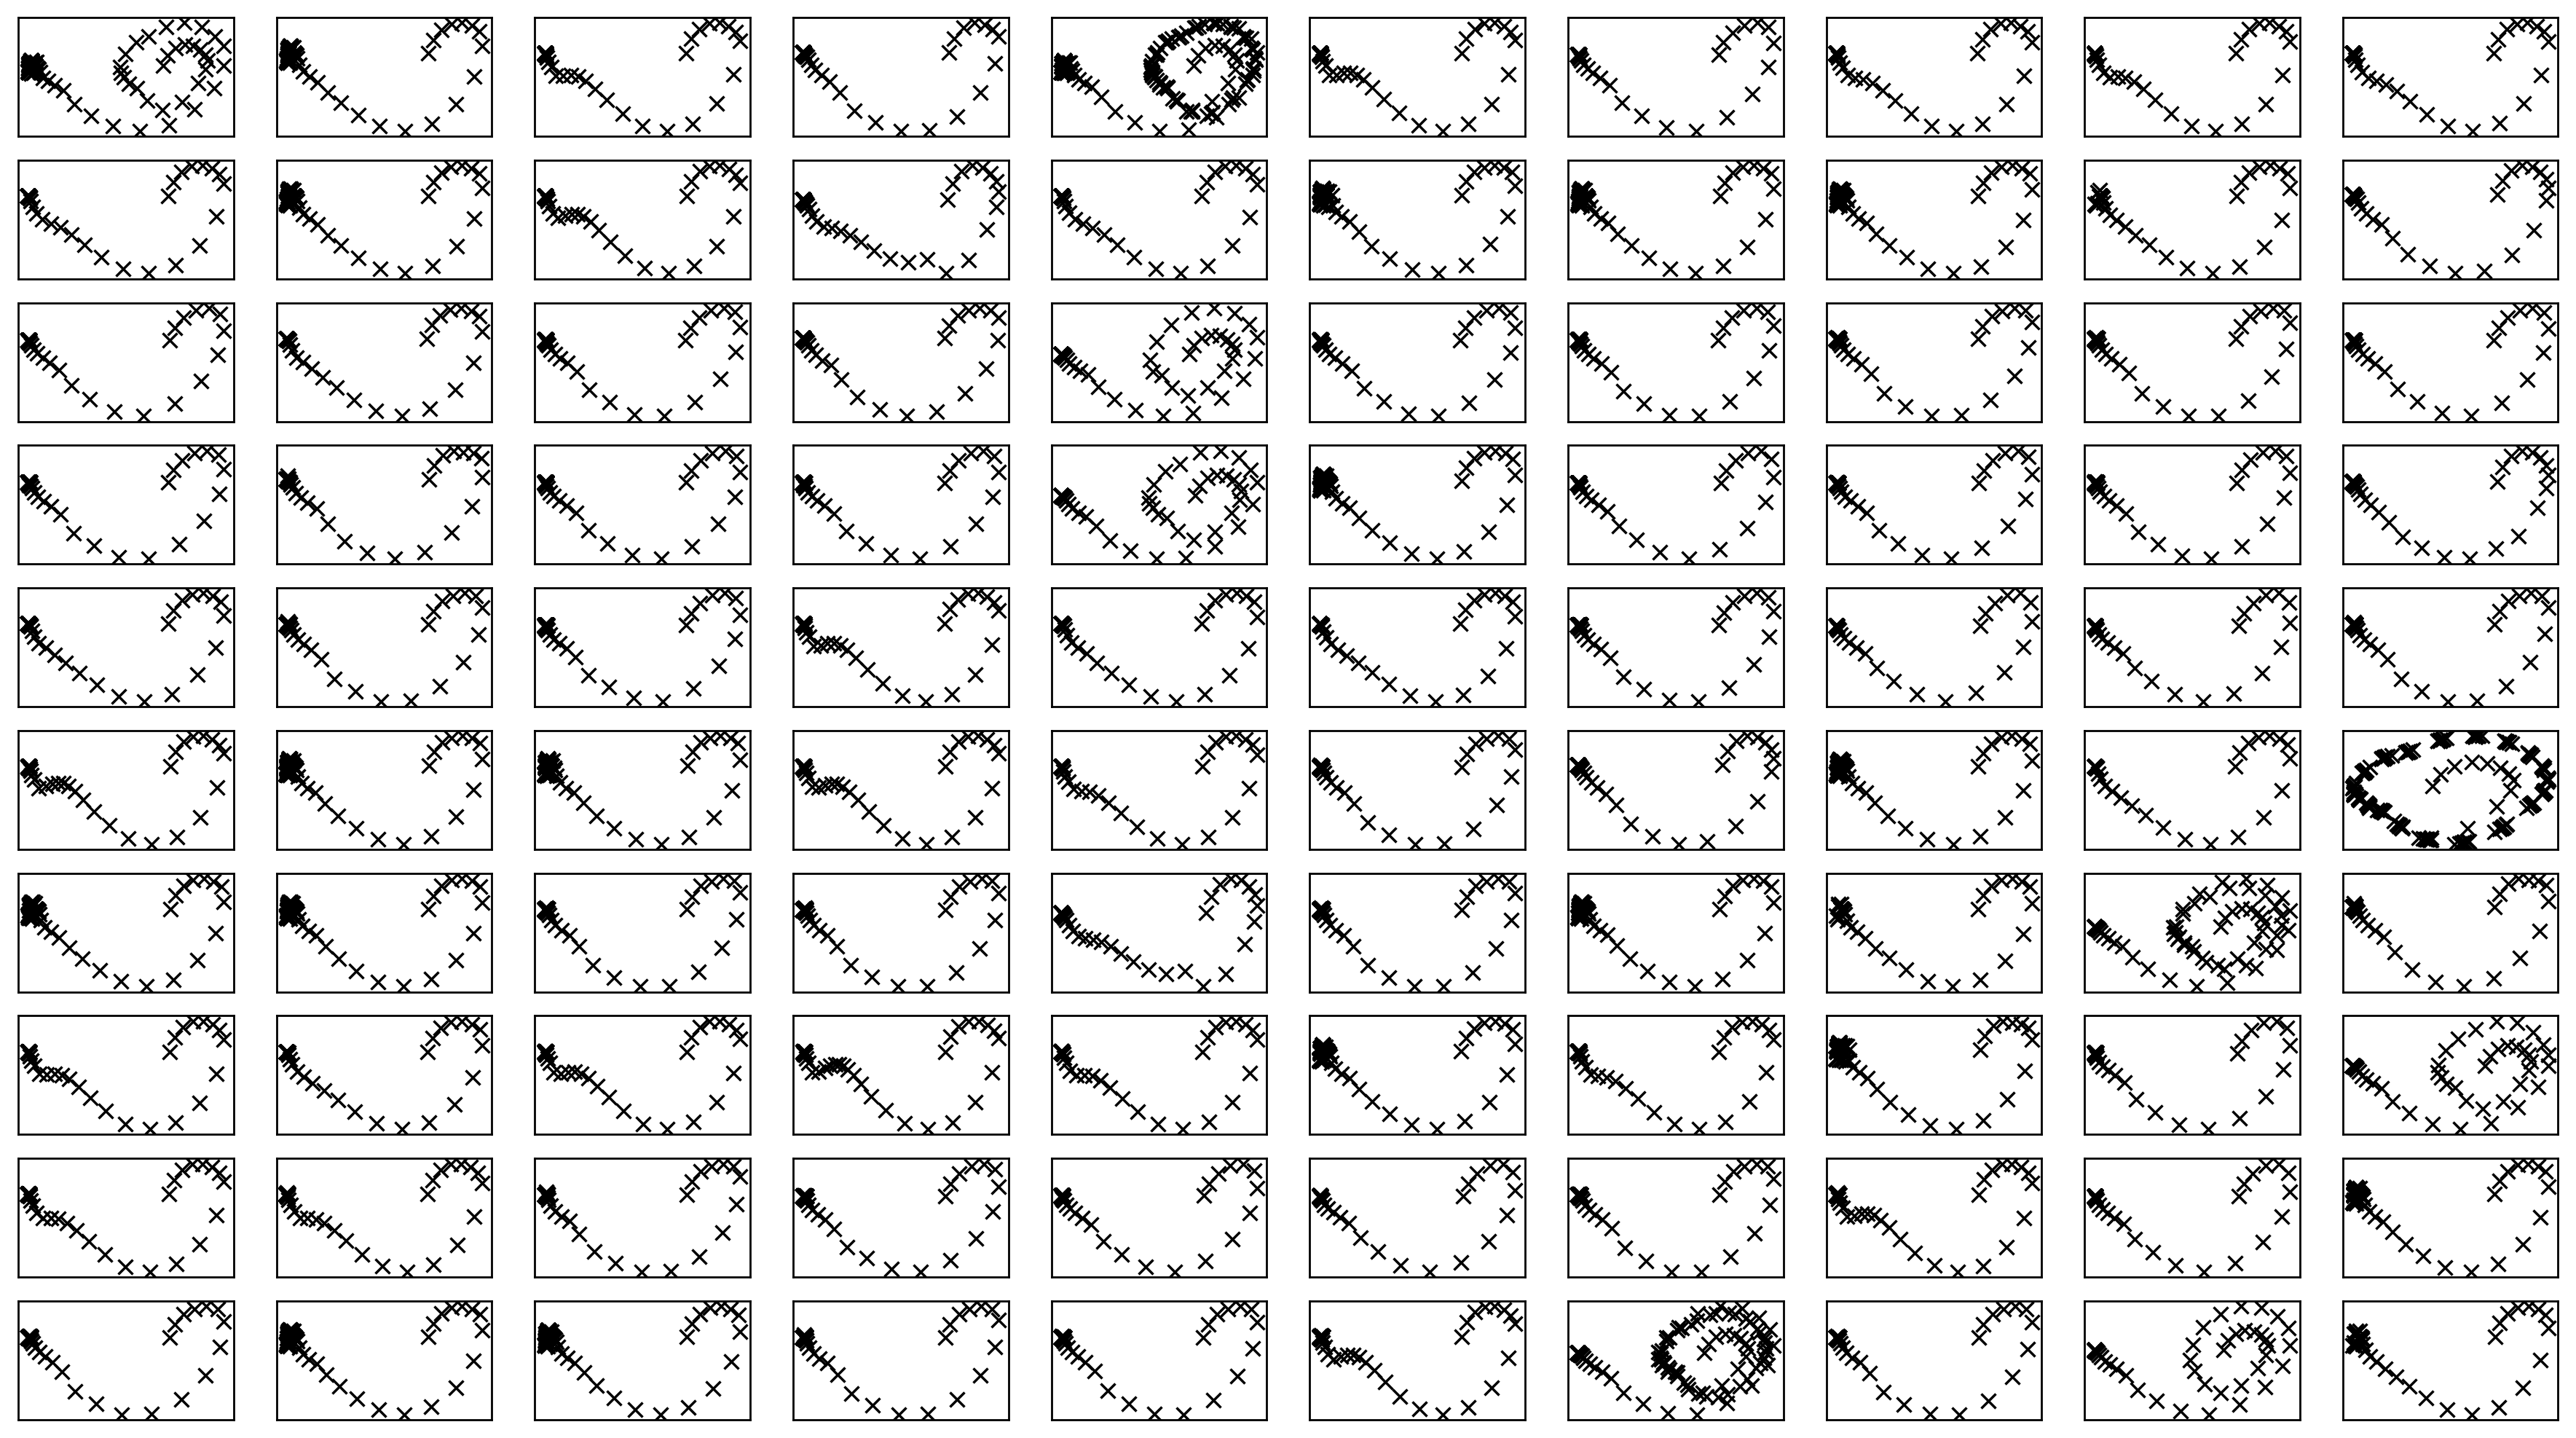

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
plt.show()

In [8]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 2.384185791015625e-07

 1 4.6837544441223145

 2 3.4254682064056396

 3 3.2199440002441406

 4 3.2768046855926514

 5 3.097665786743164

 6 3.4198756217956543

 7 3.552508592605591

 8 3.340050220489502

 9 3.3931100368499756

 10 3.607729911804199

 11 3.407867670059204

 12 3.481654405593872

 13 4.261589527130127

 14 7.01218318939209

 15 3.7196614742279053

 16 3.2792398929595947

 17 3.096457004547119

 18 3.2658679485321045

 19 3.157275438308716

 20 3.2391469478607178

 21 6.219078779220581

 22 3.041595697402954

 23 3.2523744106292725

 24 3.107762575149536

 25 3.3224754333496094

 26 5.544519424438477

 27 6.788341999053955

 28 6.638515472412109

 29 6.655849456787109

 30 6.580176830291748

 31 5.034886121749878

 32 6.368865966796875

 33 6.856247901916504

 34 6.5436248779296875

 35 6.8822033405303955

 36 3.378572940826416

 37 3.2112114429473877

 38 5.905040979385376

 39 3.266908645629883

 40 3.161154270172119

 41 3.088865041732788

 42 3.230299472808838

 4

実環境方策rollout vs Sim環境方策rollout


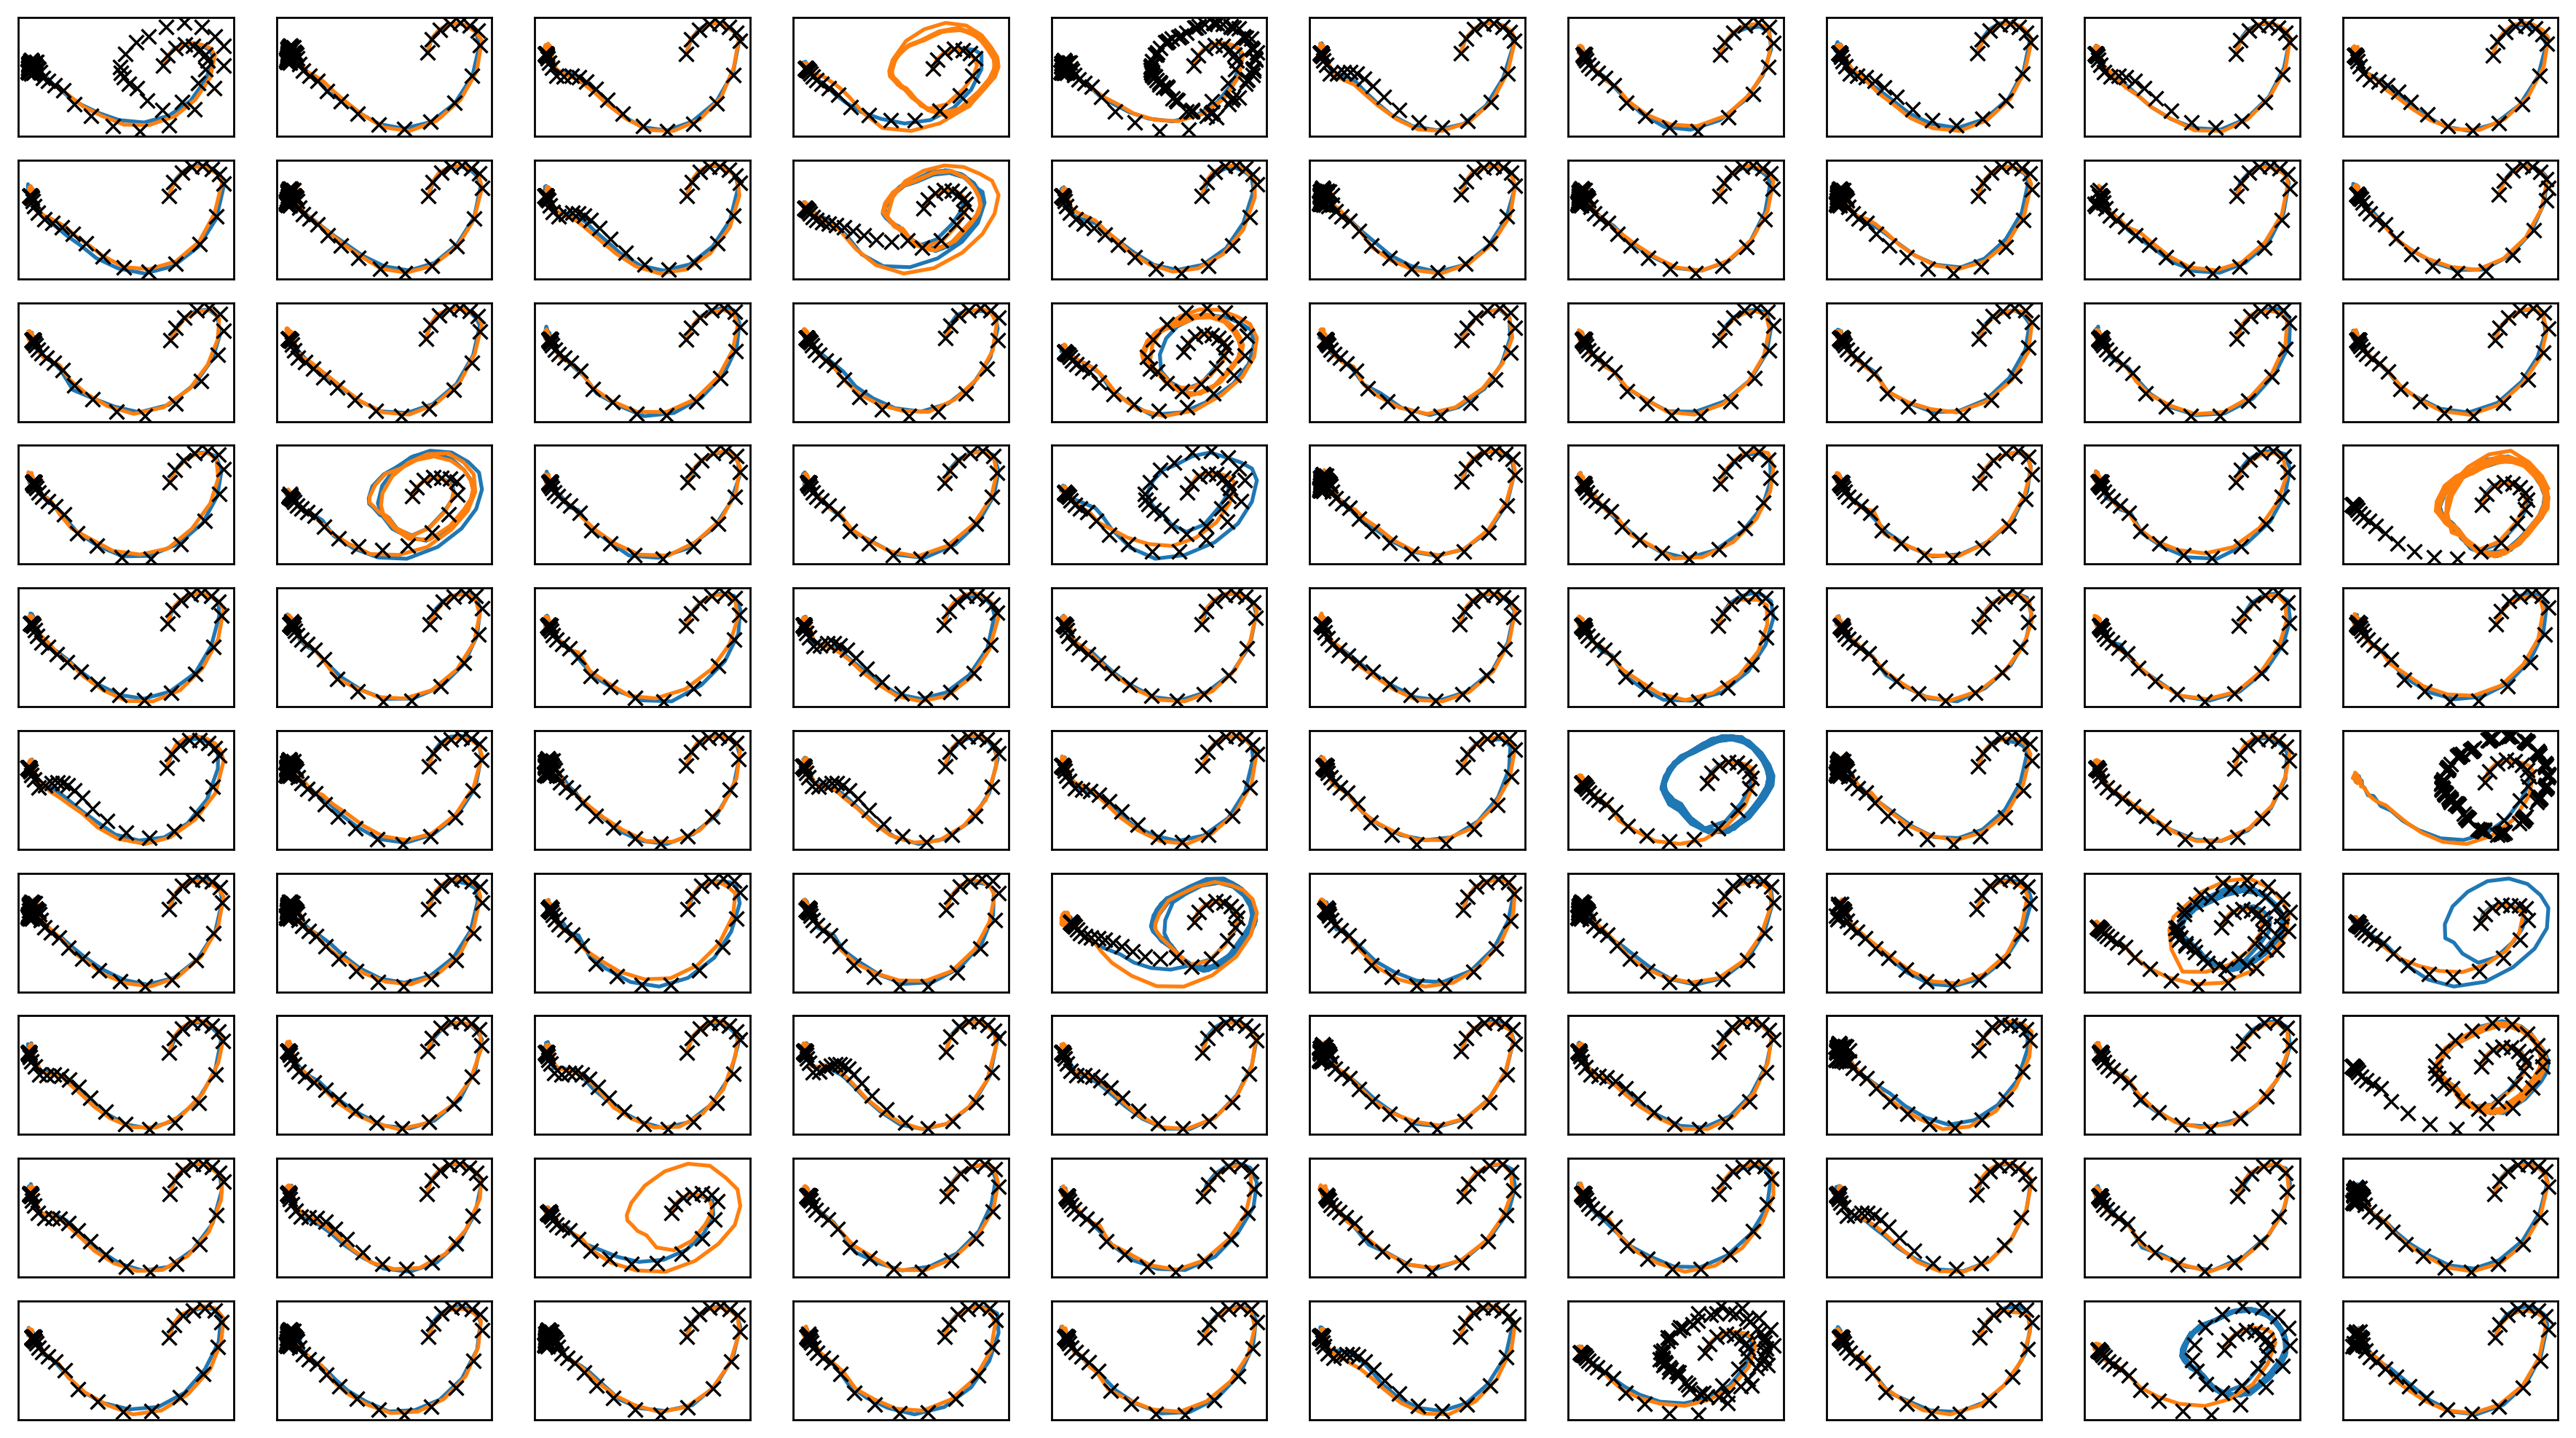

In [9]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [10]:
print(datetime.datetime.now())

2023-05-11 10:46:12.411190
